In [14]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.integrate as integrate

In [15]:
# plot utilities and settings
plt.style.use("default")

# saving plot preset
def export_plot(plot, filename, savelocation="exports/", _quality=95, _dpi=100, _optimize=True):
    """Saves a plot to the specified location."""
    plot.savefig(str(savelocation + filename), quality=_quality, dpi=_dpi, optimize=_optimize)

In [16]:
# data enumerations
VELOCITIES = "VELOCITIES"
DISTANCES = "DISTANCES"
TIME = "TIME"
X = "X"
Y = "Y"

# generate data structure
def gen_data(dataPath, time, _delimiter=",", _skip_header=1, column=4):
    """Returns a formatted dict as:
        {[VELOCITIES], [DISTANCES], TIME, COORDINATES}

        Velocity in m/s
        Distance in m
        Time in s
        X, Y in m"""
    dataSet = dict()
    # extract distances
    rawData = np.genfromtxt(dataPath, delimiter=_delimiter, skip_header=_skip_header)
    dataSet[DISTANCES] = rawData[:,column]
    # generate velocities
    dataSet[VELOCITIES] = dataSet[DISTANCES]/time
    # insert time and return
    dataSet[TIME] = time
    if rawData.shape[1] > 3:
        xs = [rawData[i][1] for i in range(rawData.shape[0])]
        ys = [rawData[i][2] for i in range(rawData.shape[0])]
        dataSet[X] = np.asarray(xs)
        dataSet[Y] = ys
    else:
        dataSet[X] = None
        dataSet[Y] = None
    return dataSet

In [17]:
# data analysis functions
# convert ms -> seconds
miliseconds_to_seconds = lambda t_ms: t_ms/1000

# convert m -> um
meter_to_micrometer = lambda t_mps: t_mps*math.pow(10, 6)
# m -> mm
meter_to_millimeter = lambda t_mps: t_mps*math.pow(10, 3)
# m -> cm
meter_to_centimeter = lambda t_mps: t_mps*math.pow(10, 2)


def gen_mean_std(data, dataName = "", silence=False):
    """Takes in a dict containing numpy-velocity data and
    outputs the mean and standard deviation."""
    mean = data[VELOCITIES].mean()  # m/s
    std = data[VELOCITIES].std()  # m/s
    _min = min(data[VELOCITIES])
    _max = max(data[VELOCITIES])

    # n, bins = np.histogram(data[VELOCITIES])
    # mids = 0.5*(bins[1:] + bins[:-1])
    # mean = np.average(mids, weights=n)
    # var = np.average((mids - mean)**2, weights=n)
    # std = np.sqrt(var)
    result = np.zeros(shape=(4,))
    result[0], result[1], result[2], result[3] = mean, std, _min, _max
    resultums = meter_to_micrometer(result)
    resultcms = meter_to_centimeter(result)
    resultmms = meter_to_millimeter(result)
    if not silence:
        print(dataName, "mean and standard deviation (m/s):", result[0:2])
        print("SD percentage:", result[1]/result[0] * 100)
        print()
    return result

In [18]:
# plot functions
def plot_velocity_distribution(ax, data, colour, fitLabel, plotScatter=True):
    # generate quadratic fit
    z = np.polyfit(data[Y], data[VELOCITIES], deg=2, full=True)
    p = np.poly1d(z[0])
    xp = np.linspace(min(data[Y]), max(data[Y]))
    # plotting scatter and quadratic fit
    if plotScatter:
        ax.plot(data[Y], data[VELOCITIES], str(colour + "o"))
    ax.plot(xp, p(xp), str(colour + ""), label=fitLabel, linewidth=2)
    return p

def plot_velocity_residuals(ax, data, fit, colour, fitLabel):
    # calculate residual
    N = len(data[VELOCITIES])
    res = np.zeros(shape=(N,))
    for i in range(N):
        res[i] = fit(data[Y][i]) - data[VELOCITIES][i]
    
    # plot residual
    ax.plot(data[Y], res, str(colour + "o"), label=fitLabel)
    return res

In [19]:
# straight height up/down
s1Time = miliseconds_to_seconds(208.1)  # seconds
s1hdPath = "data\s1hd_results.csv"
s1hd = gen_data(s1hdPath, s1Time, column=2)
s1hd_stats = gen_mean_std(s1hd, "s1hd")

s1huPath = "data\s1hu_results.csv"
s1hu = gen_data(s1huPath, s1Time, column=2)
s1hu_stats = gen_mean_std(s1hu, "s1hu")
print("Increase of {}%". format(s1hu_stats[0]/s1hd_stats[0]))

s1hd mean and standard deviation (m/s): [0.00072725 0.00040921]
SD percentage: 56.2683159235913

s1hu mean and standard deviation (m/s): [0.01031677 0.00430883]
SD percentage: 41.76524028878743

Increase of 14.186027728280036%


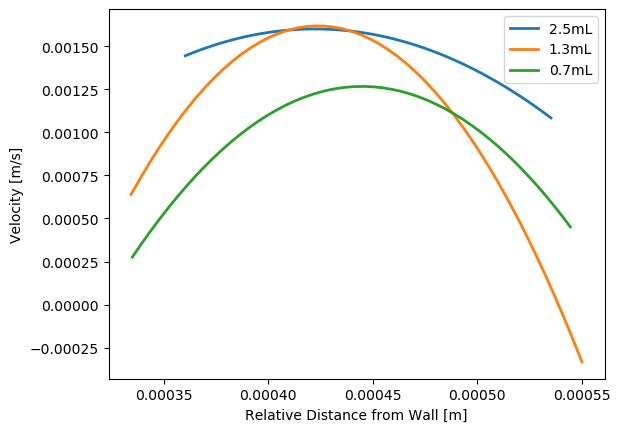

In [20]:
# volumes + velocity distributions: linear channels
s1v1Path = "data\s1v1_results.csv"
s1v1 = gen_data(s1v1Path, s1Time)
s1v2Path = "data\s1v2_results.csv"
s1v2 = gen_data(s1v2Path, s1Time)
s1v3Path = "data\s1v3_results.csv"
s1v3 = gen_data(s1v3Path, s1Time)

# volumes in mL
v1 = 2.5
v2 = 1.3
v3 = 0.7

# plot velocity distributions in single plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Relative Distance from Wall [m]")
ax.set_ylabel("Velocity [m/s]")
# plot each distribution
s1v1Fit = plot_velocity_distribution(ax, s1v1, "", str(v1)+"mL", plotScatter=False)
s1v2Fit = plot_velocity_distribution(ax, s1v2, "", str(v2)+"mL", plotScatter=False)
s1v3Fit = plot_velocity_distribution(ax, s1v3, "", str(v3)+"mL", plotScatter=False)
ax.legend()
export_plot(fig, "s1_velocity_distributions_by_volume")
# manually export b/c y-axis won't display

# max distance from set of data
minDist = 0
maxDist = 0

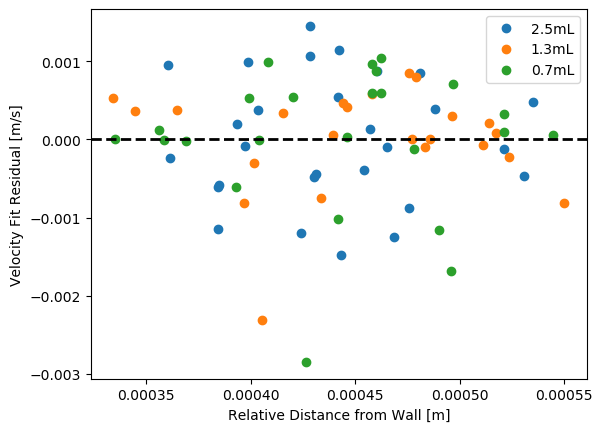

In [21]:
# plot residuals of s1v1-3 fits
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Relative Distance from Wall [m]")
ax.set_ylabel("Velocity Fit Residual [m/s]")
plot_velocity_residuals(ax, s1v1, s1v1Fit, "", str(v1)+"mL")
plot_velocity_residuals(ax, s1v2, s1v2Fit, "", str(v2)+"mL")
plot_velocity_residuals(ax, s1v3, s1v3Fit, "", str(v3)+"mL")
ax.axhline(0, color='black', linestyle="dashed", lw=2)
ax.legend()

export_plot(fig, "s1_velocity_residual_by_volume")
# manually export b/c y-axis won't display

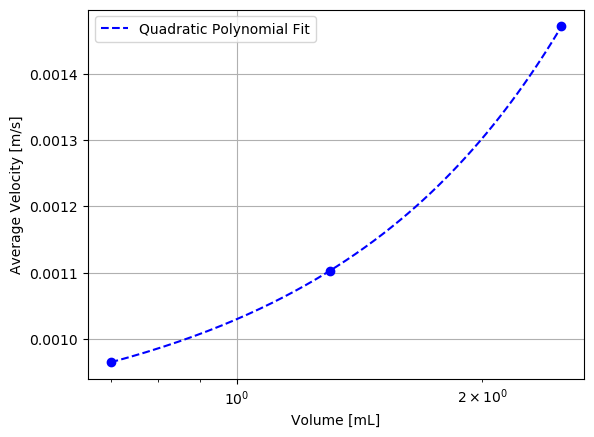

In [22]:
# velocity vs volume: linear channels
# volume array
s1Volumes = np.zeros(shape=(3,))
s1Volumes[0] = v1
s1Volumes[1] = v2
s1Volumes[2] = v3

# generate average values of fit-functions
def average_of_velocity_fits(data, fit):
    svMin = min(data[Y])  # meters
    svMax = max(data[Y])
    avgValue = integrate.quad(fit, svMin, svMax)/(svMax - svMin)
    return avgValue  # [value, upper_error]

s1v1FitAvg = average_of_velocity_fits(s1v1, s1v1Fit)
s1v2FitAvg = average_of_velocity_fits(s1v2, s1v2Fit)
s1v3FitAvg = average_of_velocity_fits(s1v3, s1v3Fit)

# use the central value for comparing peak velocities
def plot_velocity_volume(ax, volume, avgVelocity, colour="b"):
    ax.semilogx(volume, avgVelocity, str(colour + "o"))
    z = np.polyfit(volume, avgVelocity, deg=2, full=True)
    p = np.poly1d(z[0])
    xp = np.linspace(min(volume), max(volume))
    ax.semilogx(xp, p(xp), str(colour + "--"), label="Quadratic Polynomial Fit")

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Volume [mL]")
ax.set_ylabel("Average Velocity [m/s]")
velocityAvgs = [s1v1FitAvg[0], s1v2FitAvg[0], s1v3FitAvg[0]]
plot_velocity_volume(ax, s1Volumes, velocityAvgs)
ax.grid(True)
ax.legend()
export_plot(fig, "s1_average_velocity_vs_volume")





In [23]:
# width channels
c1Time = miliseconds_to_seconds(432.6)  # s
c2Time = miliseconds_to_seconds(208.1)  # s

# non-smooth channel
# v1
c1v1prePath = "data\c1e1_pre_results.csv"
c1v1pre = gen_data(c1v1prePath, c1Time)
c1v1aftPath = "data\c1e1_after_results.csv"
c1v1aft = gen_data(c1v1aftPath, c1Time)

# stats
c1v1pre_stats = gen_mean_std(c1v1pre, "c1v1pre")
c1v1aft_stats = gen_mean_std(c1v1aft, "c1v1aft")

# smooth channel
c2eprePath = "data\c2m1_results.csv"
c2eaftPath = "data\c2e3_results.csv"
c2epre = gen_data(c2eprePath, c2Time)
c2eaft = gen_data(c2eaftPath, c2Time)

# stats
c2epre_stats = gen_mean_std(c2epre, "c2epre")
c2eaft_stats = gen_mean_std(c2eaft, "c2eaft")

c1v1pre mean and standard deviation (m/s): [0.00033934 0.0001634 ]
SD percentage: 48.15209667625898

c1v1aft mean and standard deviation (m/s): [0.00047538 0.00038111]
SD percentage: 80.1709180478984

c2epre mean and standard deviation (m/s): [0.00077113 0.00044385]
SD percentage: 57.5579177033527

c2eaft mean and standard deviation (m/s): [0.00176245 0.00100156]
SD percentage: 56.8280855180503



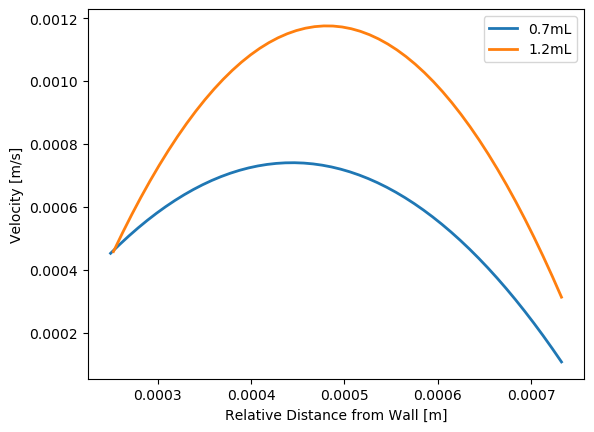

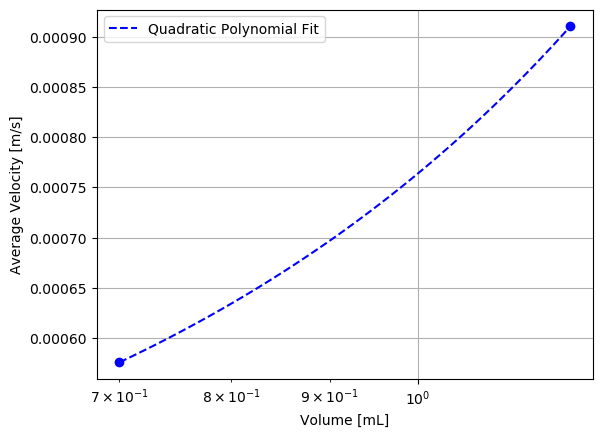

In [24]:
# velocity vs volume: width channels
c1v2prePath = "data\c1v2_pre_results.csv"
c1v2aftPath = "data\c1v2_after_results.csv"
c2v1Path = "data\c2v1_results.csv"
c2v2Path = "data\c2v2_results.csv"

c2v1 = gen_data(c2v1Path, c2Time)
c2v2 = gen_data(c2v2Path, c2Time)

v1 = 0.7  # mL
v2 = 1.2

c2Volumes = [v1 , v2]

# plot velocity distributions in single plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Relative Distance from Wall [m]")
ax.set_ylabel("Velocity [m/s]")
# plot each distribution
c2v1Fit = plot_velocity_distribution(ax, c2v1, "", str(v1)+"mL", plotScatter=False)
c2v2Fit = plot_velocity_distribution(ax, c2v2, "", str(v2)+"mL", plotScatter=False)
ax.legend()
export_plot(fig, "c2_velocity_distributions_by_volume")
# manually export b/c y-axis won't display

c2v1AvgFit = average_of_velocity_fits(c2v1, c2v1Fit)
c2v2AvgFit = average_of_velocity_fits(c2v2, c2v2Fit)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Volume [mL]")
ax.set_ylabel("Average Velocity [m/s]")
velocityAvgs = [c2v1AvgFit[0], c2v2AvgFit[0]]
plot_velocity_volume(ax, c2Volumes, velocityAvgs)
ax.grid(True)
ax.legend()
export_plot(fig, "c2_average_velocity_vs_volume")

In [35]:
# velocity before, in, and after bend
c3Time = c2Time
c5Time = c1Time
# c3paths
c3prePath = "data\c3b3_pre_results.csv"
c3inPath = "data\c3b3_bend.csv"
c3aftPath = "data\c3b3_after_results.csv"
#c3 data
c3pre = gen_data(c3prePath, c3Time)
c3in = gen_data(c3inPath, c3Time, column=3)
c3aft = gen_data(c3aftPath, c3Time)
# c3 stats
c3pre_stats = gen_mean_std(c3pre)
c3in_stats = gen_mean_std(c3in)
c3aft_stats = gen_mean_std(c3aft)

print("\n---------\nTop: edge-turns. \nBottom: sin-shaped turns\n---------\n")

c5prePath = "data\c5b2_pre_results.csv"
c5inPath = "data\c5b2_bend.csv"
c5aftPath = "data\c5b2_after_results.csv"
#c5 data
c5pre = gen_data(c5prePath, c5Time)
c5in = gen_data(c5inPath, c5Time, column=3)
c5aft = gen_data(c5aftPath, c5Time)
# c5 stats
c5pre_stats = gen_mean_std(c5pre)
c5in_stats = gen_mean_std(c5in)
c5aft_stats = gen_mean_std(c5aft)

mean and standard deviation (m/s): [0.00090156 0.00039488]
SD percentage: 43.79922595500638

 mean and standard deviation (m/s): [0.00111062 0.00050153]
SD percentage: 45.15754749867884

 mean and standard deviation (m/s): [0.00094307 0.00027969]
SD percentage: 29.65758943135186


---------
Top: edge-turns. 
Bottom: sin-shaped turns
---------

 mean and standard deviation (m/s): [1.36059793e-04 5.56423738e-05]
SD percentage: 40.895530066164376

 mean and standard deviation (m/s): [0.00021888 0.00015849]
SD percentage: 72.41228212651902

 mean and standard deviation (m/s): [0.00017621 0.00012786]
SD percentage: 72.56238507124957

